In [53]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

import matplotlib.pyplot as plt

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

from xml.etree import ElementTree as et

In [54]:
device = torch.device('cpu')

# Load your model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load("fasterrcnn.pth", map_location=device))

<All keys matched successfully>

In [55]:
# Move the model to the appropriate device
model = model.to(device)

In [56]:
def predict(images):
    model.eval()
    images = list(image.to(device) for image in images)
    outputs = model(images)
    return outputs

In [57]:
files_dir = 'data/test'
img_name = 'XAM05_YM_20150802160229_01.jpg'
img_id = img_name.split('.')[0]
imagepath = image_path = os.path.join(files_dir, img_name)
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img_res = cv2.resize(img_rgb, (1024, 1024), cv2.INTER_AREA)
img_res /= 255.0
img_rgb /= 255.0

In [58]:
def draw_boxes_on_image(boxes, images):

    for box in boxes:
        cv2.rectangle(images,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.set_axis_off()
    ax.imshow(images)
    print(f"Tassel count: {len(boxes)}")
    plt.show()

In [59]:
output_directory = 'roi/'
def extract_roi(img, boxes):
    for i, box in enumerate(boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]
        # Extract the region of interest (ROI)
        roi = img[y1:y2, x1:x2]

        # Save the ROI
        output_path = os.path.join(output_directory, f'{img_id}_{i+1}.jpg')
        cv2.imwrite(output_path, roi)

In [60]:
def resize_bbox(original_width, original_height, boxes):
    for box in boxes:
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]
        width_scale = original_width / 1024
        height_scale = original_height / 1024
        # Resize bounding box coordinates
        resized_x1 = int(x1 * width_scale)
        resized_y1 = int(y1 * height_scale)
        resized_x2 = int(x2 * width_scale)
        resized_y2 = int(y2 * height_scale)
        box[0] = resized_x1
        box[1] = resized_y1
        box[2] = resized_x2
        box[3] = resized_y2
    return boxes

In [61]:
output = predict([torch.tensor(img_res, dtype=torch.float32).permute(2, 0, 1).to(device)])
detection_threshold = 0.65
prediction_boxes = output[0]['boxes'].data.cpu().numpy()
scores = output[0]['scores'].data.cpu().numpy()

prediction_boxes = prediction_boxes[scores >= detection_threshold].astype(np.int32)

In [62]:
img.shape

(2304, 3456, 3)

In [63]:
prediction_boxes = resize_bbox(img.shape[1], img.shape[0], prediction_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED OUTPUT

Tassel count: 56


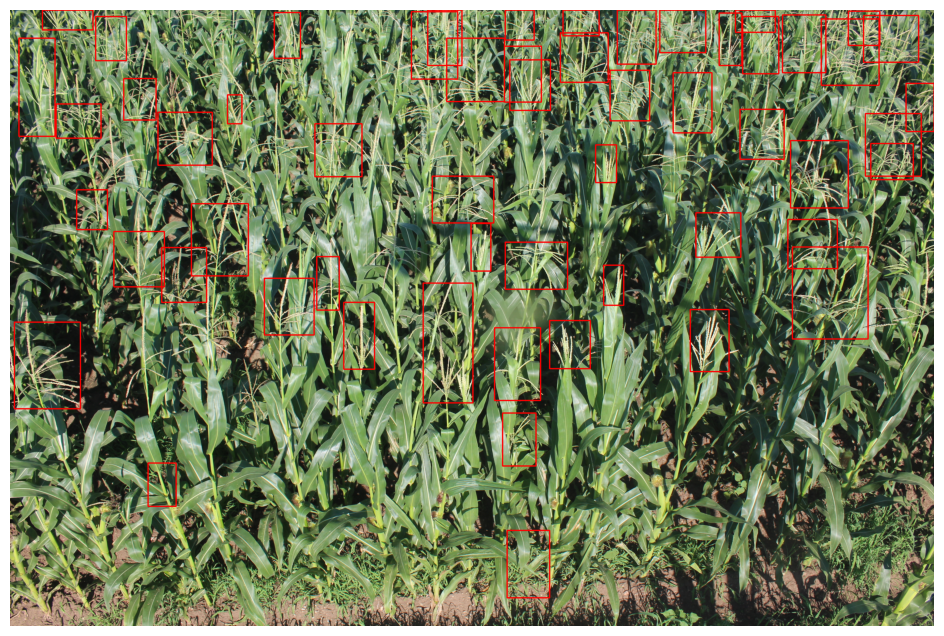

In [64]:
print("PREDICTED OUTPUT\n")
draw_boxes_on_image(prediction_boxes, img_rgb)

In [65]:
# extract_roi(img, prediction_boxes)